In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
def load_train_data():
    train_file = 'train.json.zip'
    train = pd.read_json(train_file, orient='records', convert_dates=['created'])
    train.reset_index(drop=True, inplace=True)
    return train

def load_test_data():
    test_file = 'test.json.zip'
    test = pd.read_json(test_file, orient='records', convert_dates=['created'])
    test.reset_index(drop=True, inplace=True)
    return test


# Data Preparation

In [3]:
# load train data
train = load_train_data()

# remove outliers
# latitude
lower = np.percentile(train['latitude'].values, 1)
upper = np.percentile(train['latitude'].values, 99)
train = train[train['latitude'] > lower]
train = train[train['latitude'] < upper]
# train.latitude.hist()

# longitude
lower = np.percentile(train['longitude'].values, 1)
upper = np.percentile(train['longitude'].values, 99)
train = train[train['longitude'] > lower]
train = train[train['longitude'] < upper]
# train.longitude.hist()

# price
upper = np.percentile(train['price'].values, 99)
train = train[train['price'] < upper]
# train.price.hist()

train.reset_index(drop=True, inplace=True)

# Display all building on NYC map

In [4]:
import descartes
import geopandas as gpd
from shapely.geometry import Point

def get_geometry(data):
    crs = {'init': 'epsg:4326'}
    geometry=[Point(xy)for xy in zip(data['longitude'], data['latitude'])]
    geo_df = gpd.GeoDataFrame(data,
                            crs = crs,
                            geometry = geometry)
    geo_df.reset_index(inplace=True)
    return geo_df


In [5]:
#Load backgroud NYC map data
vmap = gpd.read_file('NYC_street_map.shp')
vmap_geo = vmap.to_crs("EPSG:4326")

#Process the input data
train_geo = get_geometry(train)

fig, ax = plt.subplots(figsize = (15,15))
vmap_geo.plot(ax=ax, alpha=0.4, color="grey", edgecolor = 'k')
train_geo.plot(ax = ax, markersize = 10, color = 'red', marker = 'o', label='Building')
plt.title('Building location distribution')
plt.legend()
plt.show()

In [6]:
map_boundary = gpd.read_file('NYC_boundary.shp')
map_boundary_geo = map_boundary.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize = (15,15))
map_boundary_geo.plot(ax=ax, alpha=0.4, color='black', edgecolor='k')
train_geo.plot(ax = ax, markersize = 10, color = 'red', marker = 'o', label='Building')
plt.title('Building location distribution')
plt.legend()
plt.show()

# Feature Selection

In [7]:
# Adding feature manager id
manager_id_df = train.groupby(['manager_id']).agg({'building_id': 'count'}).reset_index()
manager_number = manager_id_df['building_id'].shape[0]
manager_id_df['building_id'] = np.linspace(1, manager_number, num=manager_number, dtype=int)

train = train.merge(manager_id_df, how='left', on='manager_id')
del train['building_id_x']
train = train.rename(columns={'building_id_y': 'manager_number'})


In [8]:
# # finding all features
# features_dict = {}
# def get_features(features):
#     for f in features:
#         f = f.strip('!')
#         f = f.strip('*')
#         f = f.strip(' ')
        
#         if f in features_dict.keys():
#             features_dict[f] += 1
#         else:
#             features_dict[f] = 1
            
# temp = train['features'].apply(get_features)
# features_dict.keys()

# feature_columns = {}
# feature_list = []
# for key in features_dict.keys():
#     if features_dict[key] >= 20000:
#         feature_list.append(key)
#         feature_columns[key] = []
        
# def get_feature_columns(features):
#     for key in feature_columns:
#         if key in features:
#             feature_columns[key].append(True)
#         else:
#             feature_columns[key].append(False)
            
# temp = train['features'].apply(get_feature_columns)
# train = pd.concat([train, pd.DataFrame.from_dict(feature_columns)], axis=1)


# using external dataset
subway = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')
subway = subway[['Station Name', 'Station Latitude', 'Station Longitude']]
subway = subway.groupby(['Station Name']).mean().reset_index(drop=True)

from math import cos, asin, sqrt
# https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula/21623206
def distance_pair(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 +  cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    d_2_point = 6371 *2 * asin(sqrt(a)) #2*R*asin...
    return d_2_point
distance_pairs = np.vectorize(distance_pair)

def get_nearby_subway(location):
    distances = distance_pairs(location[0], location[1], subway['Station Latitude'], subway['Station Longitude'])    
    return distances[distances < 1].shape[0]
    
def get_subway_distance(location):
    distances = distance_pairs(location[0], location[1], subway['Station Latitude'], subway['Station Longitude'])    
    return min(distances)

train['feature_number'] = train['features'].apply(len)
train['room_number'] = train['bedrooms'] + train['bathrooms']
train['photo_number'] = train['photos'].apply(len)
train['location'] = train[['latitude', 'longitude']].values.tolist()
train['nearby_subway'] = train['location'].apply(get_nearby_subway)
train['subway_distance'] = train['location'].apply(get_subway_distance)



# Features Selection Using Embedded Method (LassoCV())

In [9]:
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

In [10]:
# from sklearn.linear_model import LassoCV
# train['target'] = train['interest_level'].apply(lambda x: 0 if x=='low' else 1 if x=='medium' else 2)
# target = train['target']
# inputs = train[['latitude', 'listing_id', 'manager_number', 'longitude', 'bedrooms', 'bathrooms', 'photo_number', 'nearby_subway', 'subway_distance', 'price'] + feature_list]

# best_features = LassoCV().fit(inputs, target)
# print("Best alpha using built-in LassoCV: %f" % best_features.alpha_)
# print("Best score using built-in LassoCV: %f" %best_features.score(inputs, target))
# coef = pd.Series(best_features.coef_, index=inputs.columns)
# print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
# imp_coef = coef.sort_values()
# import matplotlib
# matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
# imp_coef.plot(kind = "barh")
# plt.title("Feature importance using Lasso Model")

# Training Model

In [11]:
X_features = ['feature_number', 'room_number', 'manager_number', 'photo_number', 'nearby_subway', 'subway_distance', 'price']

In [12]:
#Logistic Regression Model 1

X_old = train[['price']]
X = train[X_features]
y = train['interest_level']
logistic_model = LogisticRegression(multi_class='multinomial', max_iter=800)

scores_old = cross_val_score(logistic_model, X_old, y, cv=5)
print("Accuracy before: %f (+/- %f)" % (scores_old.mean(), scores_old.std() * 2))
scores = cross_val_score(logistic_model, X, y, cv=5)
print("Accuracy: %f (+/- %f)" % (scores.mean(), scores.std() * 2))


Accuracy before: 0.699179 (+/- 0.000104)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.690248 (+/- 0.007020)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [13]:
# # Logistic Regression Model 2
# train['high'] = train['interest_level'].apply(lambda x: True if x=='high' else False)
# train['medium'] = train['interest_level'].apply(lambda x: True if x=='medium' else False)
# train['low'] = train['interest_level'].apply(lambda x: True if x=='low' else False)

# X = train[X_features]
# y_high = train['high']
# y_medium = train['medium']
# y_low = train['low']

# lr_high = LogisticRegression(multi_class='ovr')
# lr_medium = LogisticRegression(multi_class='ovr')
# lr_low = LogisticRegression(multi_class='ovr')

# from sklearn.model_selection import cross_val_score
# scores_high = cross_val_score(lr_high, X, y_high, cv=5)
# print("Accuracy for lr_high: %f (+/- %f)" % (scores_high.mean(), scores_high.std() * 2))
# scores_medium = cross_val_score(lr_medium, X, y_medium, cv=5)
# print("Accuracy for lr_medium: %f (+/- %f)" % (scores_medium.mean(), scores_medium.std() * 2))
# scores_low = cross_val_score(lr_low, X, y_low, cv=5)
# print("Accuracy for lr_low: %f (+/- %f)" % (scores_low.mean(), scores_low.std() * 2))


# Testing Model

In [14]:
test = load_test_data()

In [15]:
test['feature_number'] = test['features'].apply(len)
test['room_number'] = test['bedrooms'] + test['bathrooms']
test['photo_number'] = test['photos'].apply(len)
test['location'] = test[['latitude', 'longitude']].values.tolist()
test['nearby_subway'] = test['location'].apply(get_nearby_subway)
test['subway_distance'] = test['location'].apply(get_subway_distance)
test = test.merge(manager_id_df, how='left', on='manager_id')
del test['building_id_x']
test = test.rename(columns={'building_id_y': 'manager_number'})

In [16]:
# test = pd.concat([test, pd.DataFrame.from_dict(feature_columns)], axis=1)

In [17]:
test_null = test[test['manager_number'].isnull()]
test_null['manager_number'] = np.zeros(test_null.shape[0])
test = test.dropna(subset=['manager_number'])
test = pd.concat([test, test_null])
test = test.astype({'manager_number':'int64'})
# test = test.astype({'Dogs Allowed':'bool', 'Hardwood Floors':'bool', 'Cats Allowed':'bool', 'Elevator':'bool'})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
X_test = test[X_features]

In [20]:
# Model 1
logistic_model.fit(X, y)
y_test = logistic_model.predict_proba(X_test)
test_data = {'listing_id':test['listing_id'], 
             'high':y_test[:,0], 
            'medium' : y_test[:,2], 
            'low' : y_test[:,1]}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Model 2
# lr_high.fit(X, y_high)
# lr_medium.fit(X, y_medium)
# lr_low.fit(X, y_low)

# y_test_high = lr_high.predict_proba(X_test)[:,1]
# y_test_medium = lr_medium.predict_proba(X_test)[:,1]
# y_test_low = lr_low.predict_proba(X_test)[:,1]


# test_data = {'listing_id' : test['listing_id'], 
#              'high' : y_test_high, 
#              'medium' : y_test_medium, 
#              'low' : y_test_low}

In [21]:
data = pd.DataFrame(data=test_data)
data

,listing_id,high,medium,low
0,7142618,0.056567,0.258484,0.684948
1,7210040,0.165063,0.283669,0.551268
2,7174566,0.087700,0.194006,0.718294
3,7191391,0.142024,0.291560,0.566416
4,7171695,0.087845,0.276031,0.636124
...,...,...,...,...
74282,6946524,0.145019,0.297458,0.557523
74312,6859027,0.113328,0.311475,0.575197
74349,6824740,0.143128,0.275501,0.581371
74517,6875490,0.000059,0.013126,0.986815


In [22]:
# data.to_csv('submission.csv', index=False)

In [ ]:
X_features

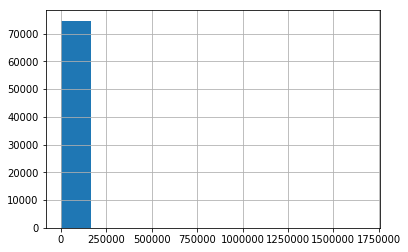

In [23]:
test.price.hist()

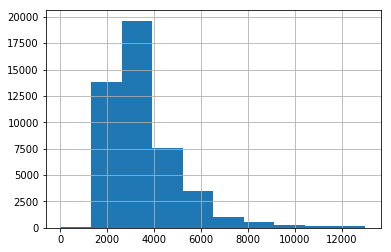

In [24]:
train.price.hist()